In [1]:
import sys
import os
import session_info

# Add the '0_functions' folder to sys.path
sys.path.append(os.path.join(os.getcwd(), '..', '0_functions'))

In [2]:
from Bio import SeqIO # NOTE: Biopython needs to be installed!
import logomaker as lm
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import plotly
from matplotlib.markers import MarkerStyle
import matplotlib.cm as cm  # Import the colormap module
from scipy.stats import fisher_exact

#import sklearn
#from sklearn.model_selection import train_test_split

from foldseek_functions import mask_all_sequences_in_fastafile

import warnings
warnings.filterwarnings(action = 'ignore')

%matplotlib inline

In [3]:
# Display session information
session_info.show()

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# Set all random seeds for reproducibility
SEED = 42

# Set seed for NumPy
np.random.seed(SEED)

# Set seed for Python's random module
random.seed(SEED)

In [6]:
# Working directory
wd =                                                               r"data/Foldseek/pren_all_C1/"
pren_filename =                                                    r"data/Foldseek/pren_all_C1/"
back_filename = r'C:/Users/ale/DataspellProjects/Prenylation_manuscript_pmc_biology/2_Background_for _Exp1&Exp2/data/Foldseek/back_all_C1'

# INPUT: Positions CSV file with C position information
c_pos_filepath = wd + "c_positions.csv"

In [7]:
# Maximum distance to C
LOCAL_RANGE = 5

# Run Foldseek on a Linux subsystem

Required Input:

    - a csv file called c_positions.csv with at least the following columns:
        - ID with Uniprot identifiers in the first column
        - N_Cpos with the position of the C residue in the amino acid sequence (from N terminal)
        - len with the length of the amino acid sequence
        
    - The parameter local_range to define how many amino acids around the C residue are included in the analysis.

- Install Foldseek from Github.
- Run bash script foldseek.sh 

In [8]:
# The output in each folder is:
# folder fastafiles -> unmasked_3di_seq.fasta
# folder plots
# c_positions.csv
# uniprot_ids.txt

In [9]:
"""

F_Count_all_1      back_Count_all_1
F_GG_Count_all_1
GG_Count_all_1

pren_all_C1        back_all_C1

pren_Ccount_1      back_Ccount_1
pren_Count_all_1   back_Count_all_1
pren_lowest_pae_1  back_lowest_pae_1
pren_pae_0         back_pae_0

"""

'\n\nF_Count_all_1      back_Count_all_1\nF_GG_Count_all_1\nGG_Count_all_1\n\npren_all_C1        back_all_C1\n\npren_Ccount_1      back_Ccount_1\npren_Count_all_1   back_Count_all_1\npren_lowest_pae_1  back_lowest_pae_1\npren_pae_0         back_pae_0\n\n'

# Get 3Di States in range 5 of cysteine

Goal: Use sequences provided in FASTA format to get a string with 5 Sdi states around the C residue of interest.

The parameter int : local_range determines what is 'too far away': Anything further than +-local_range amino acids/3di states.

Note: So far, this script only works for AlphaFold structures, not for experimental data!

Read in CSV file with C position information, required format:

    a "protein_id" column with Uniprot identifiers
    a "position" column with the position of each C
    a "len" column with the length of the reference amino acid sequence

In [10]:
c_positions = pd.read_csv(c_pos_filepath, index_col=["ID", "N_Cpos"])
c_positions.head()

,,name,quality,structure_group,Ccount,Count_all,nAA_30_180_pae,len,Cpos,pep,pepCCC,pepCC,pepCXC,pepC,lowest_pae,accs_count
ID,N_Cpos,,,,,,,,,,,,,,,
A0A1W2PQL4,90,ZN722,23.41,unstructured,27,27,0,384,-295,KHPVTCSHFTQ,NaN,NaN,NaN,KHPVTCSHFTQ,0,1
Q8TB72,169,PUM2,38.73,unstructured,10,10,0,1066,-898,GMDADCKDFNR,NaN,NaN,NaN,GMDADCKDFNR,0,1
Q8TBQ9,46,KISHA,63.71,HELX,5,5,1,72,-27,GIFWKCARIGE,NaN,NaN,NaN,GIFWKCARIGE,1,1
Q8TC12,133,RDH11,87.75,HELX,7,7,2,318,-186,AGVMMCPYSKT,NaN,NaN,NaN,AGVMMCPYSKT,2,1
Q8TCD1,71,CR032,49.99,unstructured,3,3,0,76,-6,GPTEICDKKKD,NaN,NaN,NaN,GPTEICDKKKD,0,1


In [11]:
# INPUT: Unmasked 3di sequences FASTA file generated with Foldseek
unmasked_fasta_filepath   = wd + "fastafiles/unmasked_3di_seq.fasta"

output_3di_state_filepath = wd + "3di_states.csv"

mask_all_sequences_in_fastafile(input_fasta_filepath  = unmasked_fasta_filepath, 
                                c_positions           = c_positions, 
                                local_range           = LOCAL_RANGE, 
                                output_state_filepath = output_3di_state_filepath)

ERROR: Length of Alphafold sequence does not match length of reference sequence.
Masking entire O94901 sequence; protein is ignored in subsequent analysis
Alphafold sequence length: 812
Reference sequence length: [785]
ERROR: Length of Alphafold sequence does not match length of reference sequence.
Masking entire Q03518 sequence; protein is ignored in subsequent analysis
Alphafold sequence length: 808
Reference sequence length: [748]


In [12]:
# Read in file with 3Di state of each C residue
c_3di_state_filepath = wd + r"\3di_states.csv"
states               = pd.read_csv(c_3di_state_filepath)
print('N of cysteines:', len(states))

N of cysteines: 195


In [13]:
states.head()

,id,c_position,state
0,A0A1W2PQL4,90,δδδδδδδδδδδ
1,A1L0T0,22,βββββββββββ
2,O00161,112,ηπππππββπππ
3,O00423,21,βββββππδπδπ
4,O00483,44,λπχβηδπδπβθ


In [14]:
# Master file
master_df = pd.read_csv(os.path.join('..', 'master_df.csv'), sep=',')

# Update master file
master_df['3Di_Internal_Motif'] = master_df['Protein_ID'].map(states.set_index('id')['state'])

# save
master_df.to_csv(os.path.join('..', 'master_df.csv'), sep=',', index=False)

## Create Sequence Logo from Trimmed 3Di Sequences

In [15]:
# Define the Greek alphabet
greek_alphabet = 'αβγδεηθικλμνπρστφχψω'
n_colors = len(greek_alphabet)

# Use Matplotlib's colormap to get the colors
cmap = plt.cm.tab10  # colormap
colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

# Convert RGB (from matplotlib) to Hex format
def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

# Apply the RGB to Hex conversion
colors_hex = [rgb_to_hex(c[:3]) for c in colors]

alphabet = list(greek_alphabet)
color_dict = {alphabet[i]: colors[i] for i in range(n_colors)}

In [16]:
sequences = states['state'].tolist()

In [17]:
contingency_table = lm.alignment_to_matrix(sequences)

In [18]:
def fill_missing_values(table):
    # Define the order of Greek letters
    greek_alphabet = ['α', 'β', 'γ', 'δ', 'ε', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'π', 'ρ', 'σ', 'τ', 'φ', 'χ', 'ψ', 'ω']

    # Get the columns of the original table as strings
    original_columns = table.columns.astype(str)

    # Create a new filled table with 20 columns, filled with zeros
    filled_table = pd.DataFrame(0.000, index=table.index, columns=greek_alphabet)

    # Copy the values from the original table to the filled table
    for i, letter in enumerate(greek_alphabet):
        if letter in original_columns:
            filled_table[letter] = table[letter]

    return filled_table

In [19]:
filled_table = fill_missing_values(contingency_table)

In [20]:
# save
filled_table.to_csv(rf'{wd}/state_count_matrix.csv', index=False)

Convert "alignment" to state count matrix

In [21]:
state_count_matrix = lm.alignment_to_matrix(sequences)
state_count_matrix = state_count_matrix / len(sequences)

Create and save sequence logo

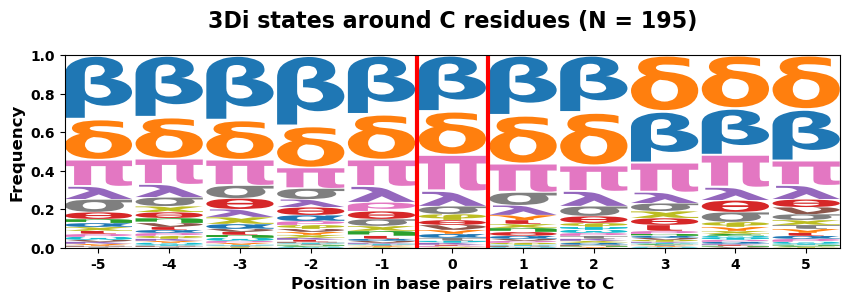

In [22]:
state_logo           = lm.Logo(state_count_matrix, 
                               color_scheme = color_dict,
                               vpad=.05)
state_logo.ax.set_xlabel("Position in base pairs relative to C", fontsize = 12)
state_logo.ax.set_xticks(range(len(state_count_matrix)))
state_logo.ax.set_xticklabels(range(-LOCAL_RANGE, len(state_count_matrix)-LOCAL_RANGE))

state_logo.ax.set_ylabel('Frequency', fontsize = 12)

state_logo.ax.axvline(4.5, color='r', linewidth=3, linestyle='-')
state_logo.ax.axvline(5.5, color='r', linewidth=3, linestyle='-')


state_logo.ax.set_title(f"3Di states around C residues (N = {len(sequences)})", fontsize = 16, y = 1.1)

state_logo_plot_path = wd + "/plots/sequence_logo_3di_states_greek.pdf"
state_logo.fig.savefig(state_logo_plot_path, bbox_inches='tight')
state_logo.fig.show("test")

# Fisher's Exact Test

In [23]:
pren_filepath = pren_filename + r"/state_count_matrix.csv"
pren = pd.read_csv(pren_filepath)
pren = pren.T

In [24]:
background_filepath = back_filename +r"/state_count_matrix.csv"
back = pd.read_csv(background_filepath)
back = back.T

In [25]:
# Perform Fisher's Exact Test for each position
results = {}
for col in pren.columns:
    p_values = []
    for state in pren.index:
        table = np.array([[pren.loc[state, col], back.loc[state, col]], 
                          [pren[col].sum() - pren.loc[state, col], back[col].sum() - back.loc[state, col]]])
        _, p = fisher_exact(table, alternative='two-sided')
        if p <= 0.05:
            p_values.append(round(p, 4))
        else:
            p_values.append(np.nan)
    results[col] = p_values

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, index=pren.index)

results_df

,0,1,2,3,4,5,6,7,8,9,10
α,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
β,NaN,NaN,NaN,NaN,NaN,0.0040,NaN,NaN,NaN,NaN,NaN
γ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
δ,0.0168,NaN,NaN,NaN,NaN,0.0189,NaN,NaN,NaN,NaN,NaN
ε,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
η,NaN,0.0387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
θ,NaN,NaN,NaN,0.0301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ι,NaN,NaN,NaN,NaN,NaN,NaN,0.0244,NaN,NaN,NaN,NaN
κ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
λ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# save
results_df.to_csv(pren_filename + r"/fisher_exact_summary.csv", encoding='utf-8-sig', index=True)

# Fisher's exact test on each position (from R)

In [27]:
import os
os.environ['R_HOME'] = 'C:/Users/ale/anaconda3/envs/CodeSIAF/Lib/R'

%load_ext rpy2.ipython

In [28]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri

# Activate the numpy to R conversion
rpy2.robjects.numpy2ri.activate()

# Load R's stats package
stats = importr('stats')

In [29]:
# Monte Carlo simulation (similar to Chi2 simulation, not an exact test anymore)

results = {}

for col in pren.columns:
    contingency_table = pd.concat([pren[col], back[col]], axis=1)
    contingency_table.columns = ['pren', 'back']
    contingency_table = np.array([[row['pren'], row['back']] for _, row in contingency_table.iterrows()])
    
    # Convert the numpy array to an R matrix
    r_matrix = ro.r.matrix(contingency_table, nrow=contingency_table.shape[0])
    
    try:
        # Perform Fisher's exact test with Monte Carlo simulation
        test_result = stats.fisher_test(r_matrix, simulate_p_value=True, B=10000)
        p_value = test_result.rx2('p.value')[0]
    except Exception as e:
        p_value = np.nan
        print(f"An error occurred for column {col}: {e}")
    
    # Store the p-value
    if p_value <= 0.05:
        results[col] = round(p_value, 4)
    else:
        results[col] = np.nan

# Create a DataFrame to store the results
results_df = pd.Series(results, name='p-value').to_frame().T

results_df


,0,1,2,3,4,5,6,7,8,9,10
p-value,NaN,NaN,NaN,NaN,0.0319,0.011,0.0435,NaN,NaN,NaN,NaN


# Visualize Frequencies for ALL positions

In [30]:
# Transform counts into frequencies

pren_freq = pren.div(pren.sum(axis=0), axis=1)
back_freq = back.div(back.sum(axis=0), axis=1)

# Convert frequencies to percentages and round to 2 decimal places
pren_perc_round = (pren_freq * 100).round().astype(int)
back_perc_round = (back_freq * 100).round().astype(int)

In [31]:
# Create df for bubble plot

pren_melted = pren_perc_round.reset_index().melt(id_vars='index', var_name='position', value_name='vals')
pren_melted = pren_melted.rename(columns={'index': 'state'})
pren_melted['dataset'] = 'pren'

back_melted = back_perc_round.reset_index().melt(id_vars='index', var_name='position', value_name='vals')
back_melted = back_melted.rename(columns={'index': 'state'})
back_melted['dataset'] = 'back'

In [32]:
plt_df = pd.concat([pren_melted, back_melted], ignore_index=True)

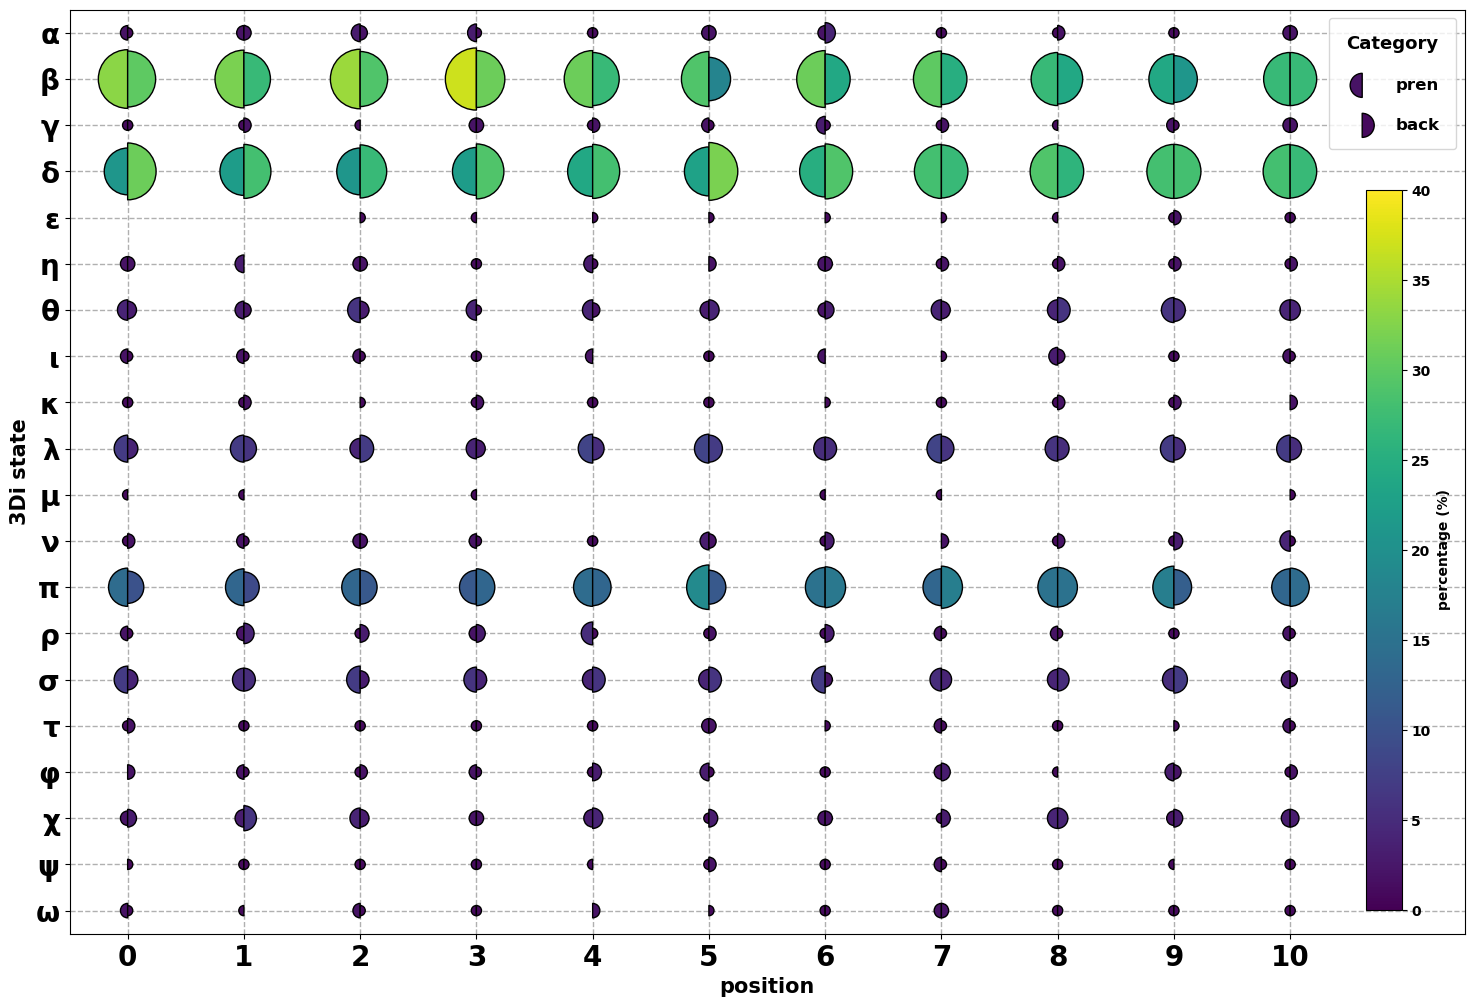

In [48]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 12))
ax.set_ylim(plt_df[Y].unique().size - 0.5, -0.5)
ax.set_xlim(-0.5, plt_df[X].unique().size + 0.5)

# Upscale factor for scatter marker size
scale = 2000 / plt_df.vals.max()

# Set the colormap range from 0 to 40
norm = plt.Normalize(vmin=0, vmax=40)  # Normalize the color scale to 0-40
cmap = plt.colormaps['viridis']

# Define colors and markers
markers = {'pren': MarkerStyle("o", fillstyle="left"), 'back': MarkerStyle("o", fillstyle="right")}

# Plot each category separately using colormap for values
for key, label in bin_dic.items():
    if label in markers:  # Ensure the category exists in the markers dictionary
        subset = plt_df[plt_df[H] == label]
        ax.scatter(
            subset[X], subset[Y], 
            s=subset.vals * scale, 
            c=cmap(norm(subset.vals)), 
            edgecolor="black", 
            marker=markers[label], 
            label=label, zorder=3
        )

# Set the x-axis labels
ax.set_xticks(range(11))

# Add labels and title with larger font size
plt.xlabel('position', fontsize=15)
plt.ylabel('3Di state', fontsize=15)

# Adjust the font size of tick labels on both axes
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# Add legend entries for the two categories in a box
l = ax.legend(
    title="Category",
    ncol=1,
    frameon=True,
    loc="upper right",
    bbox_to_anchor=(1, 1),
    columnspacing=2,
    labelspacing=1.5,
    handletextpad=1,
    borderpad=1,
    fontsize='large',
    title_fontsize='13'
)

# Adjust marker size for clarity
for handle in l.legendHandles:
    handle._sizes = [300]

# Optional: Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=1, zorder=1)

# Add a secondary axis for the colorbar to the right of the plot
cax = fig.add_axes([0.845, 0.13, 0.02, 0.6])  # Adjust the position and size as needed
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('percentage (%)', labelpad=5)

all_frequency_plot_path = wd + r"\plots\all_residues_3di_states_freq.pdf"

#plt.savefig(all_frequency_plot_path, format='pdf', bbox_inches='tight')

plt.show()


# Visualize Frequencies for cysteine position

In [34]:
plt_df_C_pos = plt_df[plt_df['position'] == 5].reset_index(drop=True)
df = plt_df_C_pos

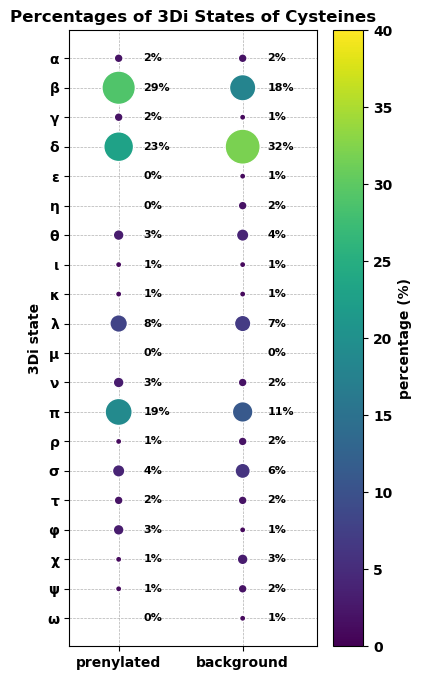

In [35]:
# Assuming df is already defined and contains the columns 'dataset', 'state', and 'vals'

# Set the colormap range from 0 to 40
norm = plt.Normalize(vmin=0, vmax=40)  # Normalize the color scale to 0-40
cmap = plt.colormaps['viridis']

# Create the scatter plot
plt.figure(figsize=(4, 8))  # Increased figure width for better padding

ax = plt.gca()
for dataset in df['dataset'].unique():
    subset = df[df['dataset'] == dataset]
    # Apply colormap based on 'vals'
    colors = cmap(norm(subset['vals']))
    # Adjust circle sizes based on 'vals'
    sizes = subset['vals'] * 20  # Scale factor for circle sizes, adjust as needed
    scatter = ax.scatter([dataset] * len(subset), subset['state'], 
                         s=sizes,  # Size of circles proportional to 'vals'
                         c=colors, edgecolors='w', label=dataset, zorder=3)
    
    # Add value annotations
    for i, row in subset.iterrows():
        # Offset to the left: converting category to numeric for adjustment
        x_pos = ['pren', 'back'].index(dataset)  # Convert category to numeric
        offset = 0.2  # Fixed offset to move text to the left
        ax.text(x_pos + offset, row['state'], f"{int(row['vals'])}%", ha='left', va='center', 
                fontsize=8, color='black', zorder=4)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='percentage (%)')

# Set x-ticks and add padding
ax.set_xticks(['pren', 'back'])
ax.set_xticklabels(['prenylated', 'background'], fontsize=10, ha='center')

plt.ylabel('3Di state', fontsize=10)
plt.title('Percentages of 3Di States of Cysteines')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)

# Reverse the order of states
ax.invert_yaxis()

# Add padding to the x-axis labels
ax.margins(x=0.6)  # Add padding around x-axis labels

# Adjust the x-axis limits to add more space on the left side
ax.set_xlim(left=ax.get_xlim()[0] + 0.2)  # Adjust the left limit of the x-axis

c_frequency_plot_path = wd + r"\plots\c_residues_3di_states_freq.pdf"

plt.savefig(c_frequency_plot_path, format='pdf', bbox_inches='tight')

plt.show()